In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import os
from sklearn.decomposition import PCA

from dredFISH.Design import PNMF
from dredFISH.Utils import basicu
from dredFISH.Utils.__init__plots import * 

import importlib
importlib.reload(PNMF)


<module 'dredFISH.Design.PNMF' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Design/PNMF.py'>

In [2]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'res_dpnmf/v_python'
print(res_dir)
fig_dir = prj_dir + 'figures/'

# data (old)
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_matrix.h5ad'
adata = anndata.read_h5ad(f, backed='r') # library size normed (no log)
# X = np.array(adata.X.todense()).copy() # already library size normalized
# adata

# data (CPM with rep)
scrna_genes_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/smrt_withrep_X_subL5n100.npy'
cell_path        = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/smrt_withrep_X_subL5n100_cells.csv'
clst_path        = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/smrt_withrep_X_subL5n100_y_L5.npy'

/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python


In [3]:
# allen scrna matrix (CPM; only 10k genes)
X = np.load(scrna_genes_path, allow_pickle=True).T # cell by gene
cells = pd.read_csv(cell_path)['0'].values
# X.sum(axis=1)
y_l5 = np.load(clst_path, allow_pickle=True)

logX = np.log10(X+1)
X.shape, logX.shape, y_l5.shape, cells.shape

((38200, 10861), (38200, 10861), (38200,), (38200,))

In [4]:
meta = adata.obs.copy()
meta = meta.loc[cells]
meta[['cluster_label', 'subclass_label', 'neighborhood_label', 'class_label']]

,cluster_label,subclass_label,neighborhood_label,class_label
SM-D9CZ6_S01_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
LS-15352_S16_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
SM-D9EPN_S55_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
SM-D9CZK_S30_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
SM-GE676_S016_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
...,...,...,...,...
SM-GE4XX_S291_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic
SM-GE4XV_S182_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic
SM-GE4WM_S007_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic
SM-GE4XV_S189_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic


In [5]:
# get the S matrix
ctrds_l3, types_l3 = basicu.group_mean(X, meta['subclass_label'].values)
print(ctrds_l3.shape)
print(types_l3)

ctrds_l2, types_l2 = basicu.group_mean(X, meta['neighborhood_label'].values)
print(ctrds_l2.shape)
print(types_l2)

ctrds_l1, types_l1 = basicu.group_mean(X, meta['class_label'].values)
print(ctrds_l1.shape)
print(types_l1)

(42, 10861)
['Astro' 'CA1-ProS' 'CA2-IG-FC' 'CA3' 'CR' 'CT SUB' 'Car3' 'DG' 'Endo'
 'L2 IT ENTl' 'L2 IT ENTm' 'L2/3 IT CTX' 'L2/3 IT ENTl' 'L2/3 IT PPP'
 'L2/3 IT RHP' 'L3 IT ENT' 'L4 RSP-ACA' 'L4/5 IT CTX' 'L5 IT CTX' 'L5 PPP'
 'L5 PT CTX' 'L5/6 IT TPE-ENT' 'L5/6 NP CTX' 'L6 CT CTX' 'L6 IT CTX'
 'L6 IT ENTl' 'L6b CTX' 'L6b/CT ENT' 'Lamp5' 'Meis2' 'Micro-PVM' 'NP PPP'
 'NP SUB' 'Oligo' 'Pvalb' 'SMC-Peri' 'SUB-ProS' 'Sncg' 'Sst' 'Sst Chodl'
 'VLMC' 'Vip']
(8, 10861)
['CGE' 'DG/SUB/CA' 'L2/3 IT' 'L4/5/6 IT Car3' 'MGE' 'NP/CT/L6b' 'Other'
 'PT']
(3, 10861)
['GABAergic' 'Glutamatergic' 'Non-Neuronal']


/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


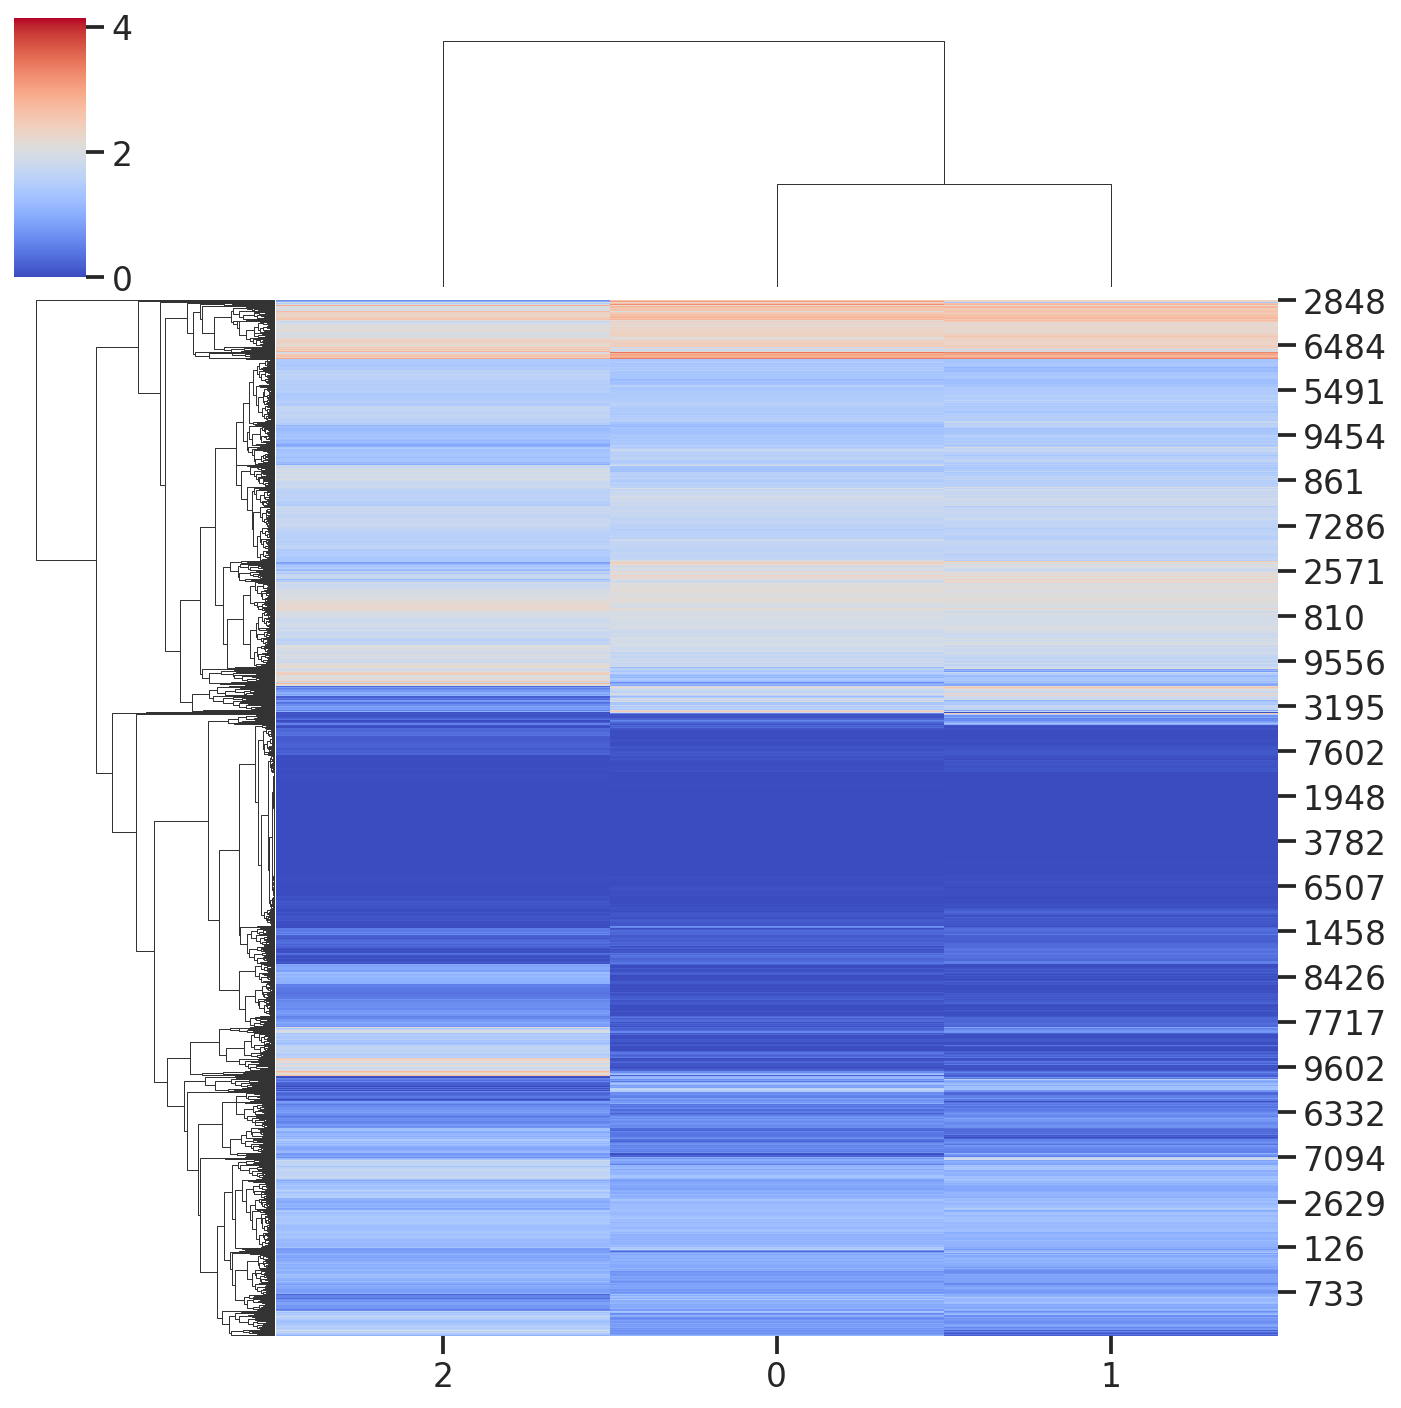

In [6]:
sns.clustermap(np.log10(ctrds_l1.T+1), cmap='coolwarm')

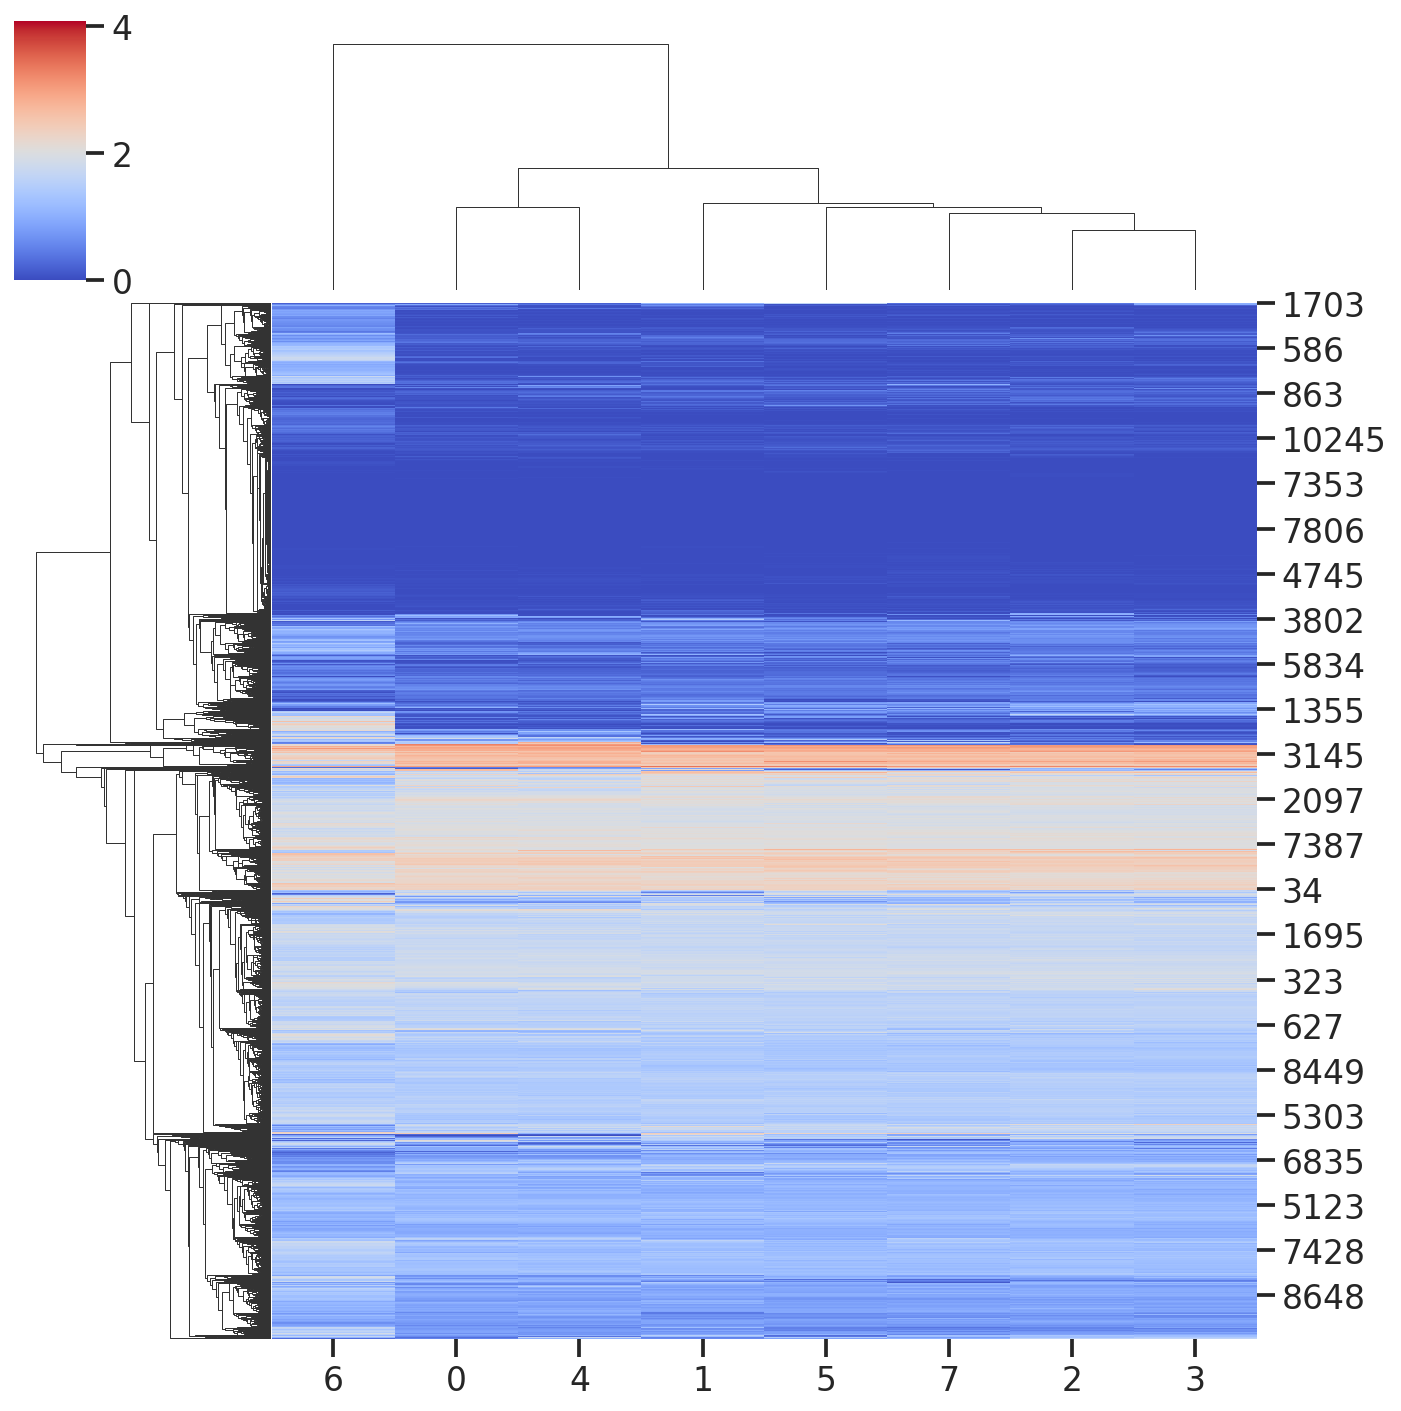

In [7]:
sns.clustermap(np.log10(ctrds_l2.T+1), cmap='coolwarm')

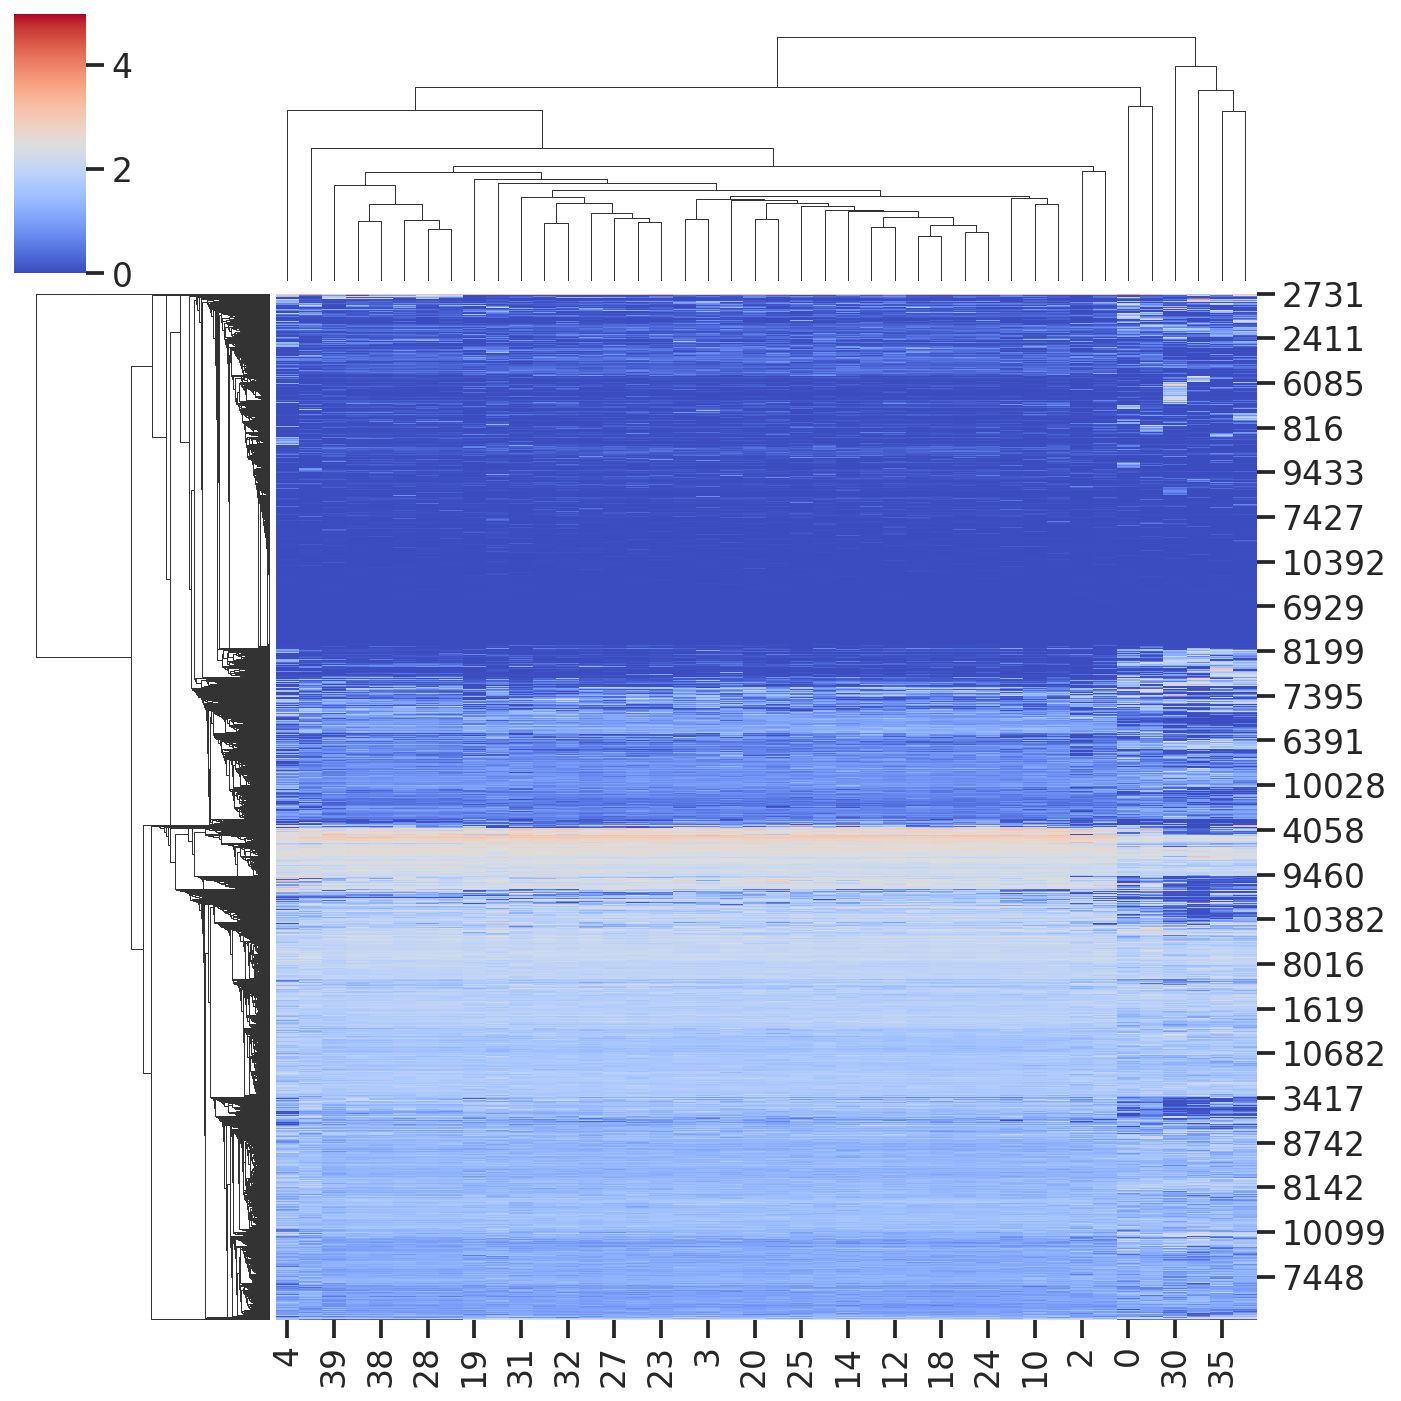

In [8]:
sns.clustermap(np.log10(ctrds_l3.T+1), cmap='coolwarm')

In [9]:
ctrds_l3.shape, ctrds_l1.shape
types_l3, types_l1

(array(['Astro', 'CA1-ProS', 'CA2-IG-FC', 'CA3', 'CR', 'CT SUB', 'Car3',
        'DG', 'Endo', 'L2 IT ENTl', 'L2 IT ENTm', 'L2/3 IT CTX',
        'L2/3 IT ENTl', 'L2/3 IT PPP', 'L2/3 IT RHP', 'L3 IT ENT',
        'L4 RSP-ACA', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PPP', 'L5 PT CTX',
        'L5/6 IT TPE-ENT', 'L5/6 NP CTX', 'L6 CT CTX', 'L6 IT CTX',
        'L6 IT ENTl', 'L6b CTX', 'L6b/CT ENT', 'Lamp5', 'Meis2',
        'Micro-PVM', 'NP PPP', 'NP SUB', 'Oligo', 'Pvalb', 'SMC-Peri',
        'SUB-ProS', 'Sncg', 'Sst', 'Sst Chodl', 'VLMC', 'Vip'],
       dtype=object),
 array(['GABAergic', 'Glutamatergic', 'Non-Neuronal'], dtype=object))

In [10]:
types_l3tol1 = meta.groupby('subclass_label')['class_label'].first().loc[types_l3].values
types_l3tol1_code, types_l1_ = pd.factorize(types_l3tol1, sort=True)
assert np.all(types_l1_ == types_l1)
ctrds_diff = ctrds_l3 - ctrds_l1[types_l3tol1_code]
print(ctrds_diff.shape)

(42, 10861)


In [11]:
# select to change exc cells only
ctrds_diff[types_l3tol1 == 'Glutamatergic'].shape #, # _code

(29, 10861)

In [12]:
cond = np.logical_or(types_l3tol1 == 'Glutamatergic', types_l3tol1 == 'GABAergic')
ctrds_diff[cond].shape

(36, 10861)

In [38]:
# get a tree
# L5 - L3 - L2 - L1
levels = [
     'class_label',
     'neighborhood_label',
     'subclass_label', 
     'cluster_label', 
    ]
tree = meta.groupby(levels).size() #['Lim1'].mean().dropna()
tree = tree[tree!=0]
tree = tree.reset_index()[levels]
tree

,class_label,neighborhood_label,subclass_label,cluster_label
0,GABAergic,CGE,Lamp5,5_Lamp5 Lhx6
1,GABAergic,CGE,Lamp5,6_Lamp5 Lhx6
2,GABAergic,CGE,Lamp5,7_Lamp5 Lhx6
3,GABAergic,CGE,Lamp5,8_Lamp5 Lhx6
4,GABAergic,CGE,Lamp5,9_Lamp5 Lhx6
...,...,...,...,...
377,Non-Neuronal,Other,SMC-Peri,381_SMC-Peri
378,Non-Neuronal,Other,SMC-Peri,382_SMC-Peri
379,Non-Neuronal,Other,VLMC,383_VLMC
380,Non-Neuronal,Other,VLMC,384_VLMC


In [39]:
for col in tree:
    print(col, len(tree[col].unique()))

class_label 3
neighborhood_label 8
subclass_label 42
cluster_label 382


In [50]:
%%time
# level 0 (global)
ctrds_, types_ = basicu.group_mean(X, ['']*len(meta))
ctrds_lvl = [ctrds_]
types_lvl = [types_]
# sub levels
for level in levels:
    print(level)
    # get centroids
    ctrds_, types_ = basicu.group_mean(X, meta[level].values)
    print(ctrds_.shape)
    print(types_.shape)
    ctrds_lvl.append(ctrds_)
    types_lvl.append(types_)

class_label
(3, 10861)
(3,)
neighborhood_label
(8, 10861)
(8,)
subclass_label
(42, 10861)
(42,)
cluster_label
(382, 10861)
(382,)
CPU times: user 1min 36s, sys: 1min 54s, total: 3min 30s
Wall time: 1min 38s


In [53]:
# a hack only run once
levels = levels[::-1]
ctrds_lvl = ctrds_lvl[::-1]
types_lvl = types_lvl[::-1]

In [60]:
len(ctrds_lvl), len(levels)

(5, 4)

In [69]:
# each sublevel gets a diff ctrds matrix
ctrds_diff_lvl = []
l2norms = []
for i in range(len(levels)):
    a = ctrds_lvl[i+1]
    b = ctrds_lvl[i]
    
    _types = types_lvl[i]
    _lc = levels[i]
    if i+1 < len(levels):
        _lu = levels[i+1]
        types_map1up = meta.groupby(_lc)[_lu].first().loc[_types].values
        types_map1up_code, _types_u = pd.factorize(types_map1up, sort=True)
        assert np.all(_types_u == types_lvl[i+1])
        
        ctrds_diff = b - a[types_map1up_code]
    else:
        ctrds_diff = b - np.repeat(a, len(b), axis=0)
    
    print(i, ctrds_diff.shape)
    norms = np.mean(np.power(ctrds_diff, 2), axis=1)
    print(np.mean(norms))
    ctrds_diff_lvl.append(ctrds_diff)
    

0 (382, 10861)
7892.724421147251
1 (42, 10861)
23238.01994346974
2 (8, 10861)
1138.7510132366938
3 (3, 10861)
12823.713642398478


array([''], dtype='<U1')

In [ ]:
%%time
Sb = ctrds_diff.T.dot(ctrds_diff)
Sb.shape

In [ ]:
%%time
# # # # run PNMF orig -- what we do and have to do
# w_pca, rec_pca = PNMF.get_PNMF(X[:,:1000].T, init='pca',     k=24, verbose=True, report_stride=30)
# w_p2x, rec_p2x = PNMF.get_PNMF(X.T, init='pca_2x',  k=24, verbose=True, report_stride=30)
# w_nrm, rec_nrm = PNMF.get_PNMF(X.T, init='normal',  k=24, verbose=True, report_stride=30)
w_uni, rec_uni = PNMF.get_PNMF(X[:,:1000].T, init='uniform', k=24, verbose=True, report_stride=30)

In [ ]:
w_uni_mu100, rec_uni_mu100 = PNMF.get_DPNMF(X[:,:1000].T, 24, -Sb[:1000,:1000], 100,
                                            init='uniform', verbose=True, report_stride=30)

In [ ]:
# plt.plot(rec_pca[:,0], rec_pca[:,1], label='pca')
# plt.plot(rec_p2x[:,0], rec_p2x[:,1], label='pca_2x')
# plt.plot(rec_nrm[:,0], rec_nrm[:,1], label='random normal')
plt.plot(rec_uni[:,0], rec_uni[:,1], label='random uniform')
plt.plot(rec_uni_mu100[:,0], rec_uni_mu100[:,1], label='random uniform')
plt.xlabel('Iterations')
plt.ylabel('Update rate')
plt.legend()
plt.yscale('log')
# plt.xscale('log')

In [ ]:
def plot(w, ax, vmax=None, reorder=True):
    if reorder:
        wnew, rows, cols = basicu.diag_matrix_rows(w)
    else:
        wnew = w
        
    sns.heatmap(
                # np.log10(wnew+1), 
                wnew,
                ax=ax, 
                cmap='rocket_r', 
                cbar_kws=dict(shrink=0.5),
                vmax=vmax,
               )

In [ ]:
def calc_err(x, w, rho=1):
    """
    X: (p, n)
    w: (p, k)
    """
    return np.linalg.norm(x-rho*w.dot(w.T.dot(x)), ord='fro')**2

def calc_ss(x):
    """
    X: (p, n)
    """
    xmean = np.mean(x, axis=1)
    xcentered = x-xmean.reshape(-1,1)
    return (np.linalg.norm(xcentered, ord='fro')**2)

def calc_r2(x, w):
    """
    X: (p, n)
    w: (p, k)
    """
    xmean = np.mean(x, axis=1)
    xcentered = x-xmean.reshape(-1,1)
    return 1 - calc_err(x, w)/calc_ss(x)

In [ ]:
r2s = []
ks = np.array([2,5,10,16,24,48,100])
for k in ks:
    print(k)
    Xmat = X[:,:500].T.copy()
    w_uni, rec_uni = PNMF.get_PNMF(Xmat, init='uniform', k=k, verbose=True, report_stride=30)
    r2 = calc_r2(Xmat, w_uni)
    r2s.append(r2)
r2s = np.array(r2s)

In [ ]:
# compare with PCA
res_pca = PCA(n_components=100).fit(Xmat)
var_ratios = res_pca.explained_variance_ratio_
cum_var_ratios = np.cumsum(var_ratios)

In [ ]:
cum_var_ratios

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ks, r2s, '-o', label="PNMF")
ax.plot(ks, cum_var_ratios[ks-1], '-o', label="PCA")
# ax.plot(2*ks, cum_var_ratios[ks-1], '--o', label="PCA (2x)", color='gray')
ax.set_xlabel("Number of components (k)")
ax.set_ylabel("Explained variance ratio")
ax.set_ylim([0,1])
ax.legend(bbox_to_anchor=(1,1))
ax.set_title(f"Test: {len(Xmat)} genes by 100 cells per L5 (~300) types")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ks, r2s, '-o', label="PNMF")
ax.plot(ks, cum_var_ratios[ks-1], '-o', label="PCA")
ax.plot(2*ks, cum_var_ratios[ks-1], '--o', label="PCA (2x)", color='gray')
ax.set_xlabel("Number of components (k)")
ax.set_ylabel("Explained variance ratio")
ax.set_ylim([0,1])
ax.legend(bbox_to_anchor=(1,1))
ax.set_title(f"Test: {len(Xmat)} genes by 100 cells per L5 (~300) types")
plt.show()

In [ ]:
vmax = 0.1
# vmax = 0.03
fig, axs = plt.subplots(1, 4, figsize=(7*4,8))
# ax = axs[0]
# plot(w_pca, ax, vmax=vmax)
# ax.set_title('|PCA|')

# ax = axs[1]
# plot(w_p2x, ax, vmax=vmax)
# ax.set_title('PCA 2x')

# ax = axs[2]
# plot(w_nrm, ax, vmax=vmax)
# ax.set_title('random |~Normal|')

ax = axs[3]
plot(w_uni, ax, vmax=vmax)
ax.set_title('random ~Uniform')
fig.suptitle('*rows are different')
plt.show()

In [ ]:
# vmax = 0.1
# # vmax = 0.03
# # set the order
# wnew, rows, cols = basicu.diag_matrix_rows(w_pca)
# # wnew, rows, cols = basicu.diag_matrix_rows(w_p2x)

# fig, axs = plt.subplots(1, 4, figsize=(7*4,8))
# ax = axs[0]
# wnew = w_pca[rows]
# plot(wnew, ax, vmax=vmax, reorder=False)
# ax.set_title('|PCA|')

# ax = axs[1]
# wnew = w_p2x[rows]
# plot(wnew, ax, vmax=vmax, reorder=False)
# ax.set_title('PCA 2x')

# ax = axs[2]
# wnew = w_nrm[rows]
# plot(wnew, ax, vmax=vmax, reorder=False)
# ax.set_title('random |~Normal|')

# ax = axs[3]
# wnew = w_uni[rows]
# plot(wnew, ax, vmax=vmax, reorder=False)
# ax.set_title('random ~Uniform')

# fig.suptitle('*rows are aligned')
# plt.show()

# save and validate these


In [ ]:
# output = os.path.join(res_dir, "smrt_X_v2_DPNMF.h5ad")
# res_adata = anndata.AnnData(w_pca)
# res_adata.layers['w_pca'] = w_pca
# res_adata.layers['w_p2x'] = w_p2x
# res_adata.layers['w_nrm'] = w_nrm
# res_adata.layers['w_uni'] = w_uni
# res_adata

In [ ]:
# res_adata.write(output)

In [ ]:
# b = anndata.read(output)
# b